In [1]:
import numpy as np
p = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\Output\\eddy_prob\\eddy_prob_t00000.npy")
print(p.min(), p.max(), p.mean(), (p>0).mean())


0.0 1.0 0.24721035 0.26232993197278914


In [2]:
m = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\eddy_mask_2000-2010.npy")[0]  # 0/1/2
pred = (p >= 0.5).astype(np.int32)
gt = (m > 0).astype(np.int32)
iou = (pred & gt).sum() / ((pred | gt).sum() + 1e-6)
print("IoU:", iou)


IoU: 0.5595441594644524


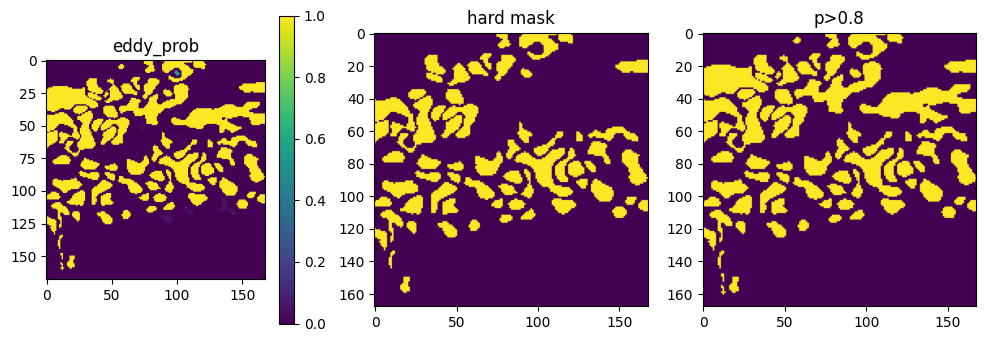

In [19]:
import numpy as np
import matplotlib.pyplot as plt

pwd = "D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\"

a = 100
p = np.load(f"{pwd}Output\\eddy_prob\\eddy_prob_t{a:05d}.npy")
m = np.load(f"{pwd}data\\eddy_mask_2000-2010.npy")[a]  # 原 hard mask

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("eddy_prob"); plt.imshow(p); plt.colorbar()
plt.subplot(1,3,2); plt.title("hard mask"); plt.imshow(m>0)
plt.subplot(1,3,3); plt.title("p>0.8"); plt.imshow(p>=0.8)
plt.show()


In [1]:
import numpy as np
d = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\pretain\\components_train.npz")
x = d["patches"]
print("shape:", x.shape)
print("has_nan:", np.isnan(x).any(), "has_inf:", np.isinf(x).any())
print("min/max:", np.nanmin(x), np.nanmax(x))

shape: (413381, 1, 32, 32)
has_nan: False has_inf: False
min/max: -1.4517 1.5529


In [2]:
import numpy as np
d = np.load(r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\data\pretain\components_train.npz")
x = d["patches"]
areas = d["areas"]
labels = d["labels"]
print("patch finite:", np.isfinite(x).all(), "min/max:", x.min(), x.max())
print("areas min/max:", areas.min(), areas.max(), "in_range:", ((areas>=15)&(areas<=400)).mean())
print("labels sum:", labels.sum(), "N:", len(labels))


patch finite: True min/max: -5.0 5.0
areas min/max: 1 3021 in_range: 0.6114165866355735
labels sum: 205771 N: 413381


In [3]:
import numpy as np

d = np.load(r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\data\pretain\components_train.npz")
areas = d["areas"]
labels = d["labels"].astype(np.int64)

area_ok = (areas >= 15) & (areas <= 400)
conflict = (labels == 1) & (~area_ok)

print("area_ok ratio:", area_ok.mean())
print("labels==1 ratio:", (labels==1).mean())
print("conflict ratio among all:", conflict.mean(), "conflict count:", conflict.sum())
print("conflict ratio among positives:", conflict.sum() / max(1, (labels==1).sum()))


area_ok ratio: 0.6114165866355735
labels==1 ratio: 0.4977756597424652
conflict ratio among all: 0.0 conflict count: 0
conflict ratio among positives: 0.0


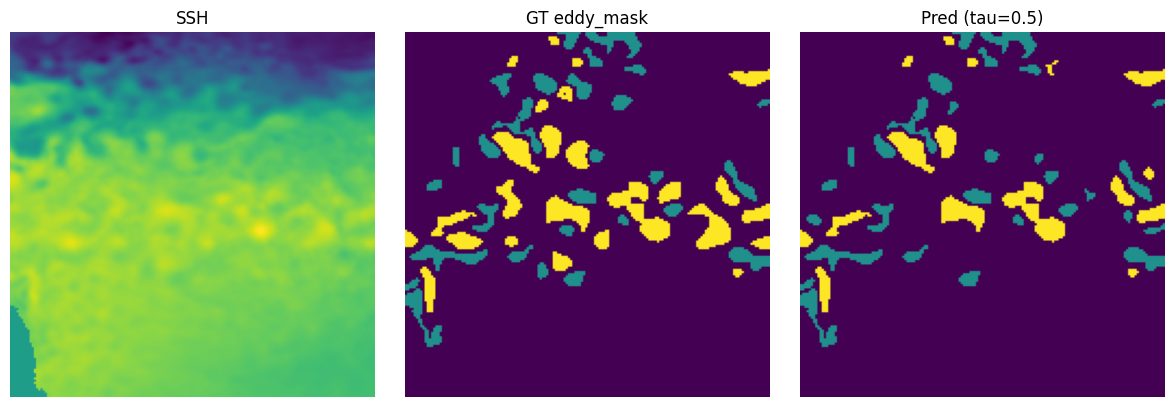

[POS] P=0.974 R=0.614 F1=0.753 IoU=0.604  (tp=1304, fp=35, fn=821)
[NEG] P=0.928 R=0.864 F1=0.895 IoU=0.810  (tp=1506, fp=116, fn=237)
[EDDY]P=0.949 R=0.726 F1=0.823 IoU=0.699  (tp=2810, fp=151, fn=1058)


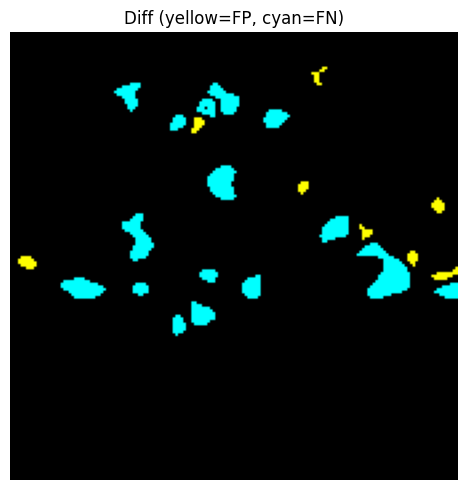

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import label, find_objects
import matplotlib.pyplot as plt

# ===== 路径：按你本地改 =====
SEEDNET_PT = r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\Code_test\Output_fasttrain\seednet_epoch5.pt"

SSH_2011 = r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\data\testAVISO-SSH_2011.npy"
POS_GROW_2011 = r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\data\facts\facts_pos_grow_2011.npy"
NEG_GROW_2011 = r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\data\facts\facts_neg_grow_2011.npy"
OCEAN_2011    = r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\data\facts\facts_ocean_2011.npy"
GT_2011       = r"D:\Desktop\Neural Symbolic\Code\GITCode\EddyNN-DeepProblog\data\eddy_mask_2011.npy"

DAY = 10          # 先随便挑一天
TAU_KEEP = 0.5    # 阈值
MIN_AREA, MAX_AREA = 15, 400
PATCH = 32

# 若你的 SSH 是 (T,H,280)，需要裁 ROI；若已是 (T,168,168) 则不裁
Y0, BOX, W_FULL = 25, 168, 280
def maybe_crop_to_roi(arr):
    if arr.shape[1] == BOX and arr.shape[2] == BOX:
        return arr
    x0 = W_FULL - BOX
    return arr[:, Y0:Y0+BOX, x0:x0+BOX]

def structure8():
    return np.ones((3,3), dtype=int)

def crop_centered_patch(img2d, sl, patch=32):
    y0, y1 = sl[0].start, sl[0].stop
    x0, x1 = sl[1].start, sl[1].stop
    cy = (y0 + y1) // 2
    cx = (x0 + x1) // 2
    half = patch // 2
    ys = max(0, cy-half); ye = min(img2d.shape[0], cy+half)
    xs = max(0, cx-half); xe = min(img2d.shape[1], cx+half)
    out = np.zeros((patch, patch), np.float32)
    out[(half-(cy-ys)):(half+(ye-cy)), (half-(cx-xs)):(half+(xe-cx))] = img2d[ys:ye, xs:xe]
    return out

def normalize_patch(p, eps=1e-6, clip=5.0):
    p = np.nan_to_num(p, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    m, s = p.mean(), p.std()
    if s < eps:
        return np.zeros_like(p, np.float32)
    p = (p - m) / (s + eps)
    p = np.clip(p, -clip, clip)
    return p.astype(np.float32)

class SeedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 64), nn.ReLU(),
            nn.Linear(64, 2),
        )
    def forward(self, x):
        logits = self.net(x)
        return F.softmax(logits, dim=-1)

@torch.no_grad()
def predict_mask_for_day(net, ssh2d, pos_grow2d, neg_grow2d, ocean2d, device):
    H, W = ssh2d.shape
    oc = ocean2d.astype(bool)
    S = structure8()

    prob_pos = np.zeros((H,W), np.float32)
    prob_neg = np.zeros((H,W), np.float32)

    def run_one(grow2d, prob_map):
        grow = (grow2d.astype(bool) & oc)
        lab, n = label(grow.astype(np.uint8), structure=S)
        if n == 0:
            return
        areas = np.bincount(lab.ravel())
        sls = find_objects(lab)

        patches, metas = [], []
        for cid in range(1, n+1):
            area = int(areas[cid])
            if area < MIN_AREA or area > MAX_AREA:
                continue
            sl = sls[cid-1]
            if sl is None:
                continue
            region = (lab[sl] == cid)
            if region.sum() == 0:
                continue
            p = crop_centered_patch(ssh2d, sl, PATCH)
            p = normalize_patch(p)
            patches.append(p[None,None,...])
            metas.append((sl, region))

        if not patches:
            return

        x = torch.from_numpy(np.concatenate(patches, axis=0)).to(device)
        probs = net(x).cpu().numpy()
        p_keep = probs[:,1]

        for (sl, region), pk in zip(metas, p_keep):
            if pk >= TAU_KEEP:
                block = prob_map[sl]
                block[region] = np.maximum(block[region], float(pk))
                prob_map[sl] = block

    run_one(pos_grow2d, prob_pos)
    run_one(neg_grow2d, prob_neg)

    pred = np.zeros((H,W), np.int8)
    pred[(prob_neg >= TAU_KEEP) & (prob_neg > prob_pos)] = 1
    pred[(prob_pos >= TAU_KEEP) & (prob_pos >= prob_neg)] = 2
    return pred

# ===== 评估与差异图（放在 main 外面，才能在 main 里调用）=====
def pr_f1_iou(pred, gt, cls):
    tp = int(((pred == cls) & (gt == cls)).sum())
    fp = int(((pred == cls) & (gt != cls)).sum())
    fn = int(((pred != cls) & (gt == cls)).sum())
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    iou  = tp / (tp + fp + fn + 1e-9)
    return prec, rec, f1, iou, tp, fp, fn

def eval_one_day(pred, gt):
    pos = pr_f1_iou(pred, gt, 2)
    neg = pr_f1_iou(pred, gt, 1)

    pred_e = (pred > 0).astype(np.uint8)
    gt_e   = (gt > 0).astype(np.uint8)
    eddy = pr_f1_iou(pred_e, gt_e, 1)

    print(f"[POS] P={pos[0]:.3f} R={pos[1]:.3f} F1={pos[2]:.3f} IoU={pos[3]:.3f}  (tp={pos[4]}, fp={pos[5]}, fn={pos[6]})")
    print(f"[NEG] P={neg[0]:.3f} R={neg[1]:.3f} F1={neg[2]:.3f} IoU={neg[3]:.3f}  (tp={neg[4]}, fp={neg[5]}, fn={neg[6]})")
    print(f"[EDDY]P={eddy[0]:.3f} R={eddy[1]:.3f} F1={eddy[2]:.3f} IoU={eddy[3]:.3f}  (tp={eddy[4]}, fp={eddy[5]}, fn={eddy[6]})")

def plot_diff(pred, gt, title="Diff (yellow=FP, cyan=FN)"):
    pe = (pred > 0)
    ge = (gt > 0)
    fp = pe & (~ge)
    fn = ge & (~pe)

    img = np.zeros((*pred.shape, 3), dtype=np.float32)
    img[fp] = [1, 1, 0]   # FP = yellow
    img[fn] = [0, 1, 1]   # FN = cyan

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ssh = maybe_crop_to_roi(np.load(SSH_2011).astype(np.float32))
    pg  = maybe_crop_to_roi(np.load(POS_GROW_2011).astype(np.uint8))
    ng  = maybe_crop_to_roi(np.load(NEG_GROW_2011).astype(np.uint8))
    oc  = maybe_crop_to_roi(np.load(OCEAN_2011).astype(np.uint8))
    gt  = maybe_crop_to_roi(np.load(GT_2011).astype(np.int8))

    net = SeedNet().to(device)
    net.load_state_dict(torch.load(SEEDNET_PT, map_location="cpu"))
    net.eval()

    pred = predict_mask_for_day(net, ssh[DAY], pg[DAY], ng[DAY], oc[DAY], device)

    # 可视化：SSH、GT、Pred
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(ssh[DAY])
    ax[0].set_title("SSH")
    ax[1].imshow(gt[DAY], vmin=0, vmax=2)
    ax[1].set_title("GT eddy_mask")
    ax[2].imshow(pred, vmin=0, vmax=2)
    ax[2].set_title(f"Pred (tau={TAU_KEEP})")
    for a in ax: 
        a.axis("off")
    plt.tight_layout()
    plt.show()

    # ===== 关键：打印指标 + 画差异图 =====
    eval_one_day(pred, gt[DAY])
    plot_diff(pred, gt[DAY])

if __name__ == "__main__":
    main()
